## Understanding the Dataset

First, we have a peek into the dataset and visualise what kind of data we have, the classes and labels associated with it.

The Libraries we will be using includes standard python libraries `os` for fetching the directory and path, `matplotlib.pyplot` for visualizations, `pandas` for reading the csv files, `imread` from `matplotlib.image` for reading images into an array.

From the `trafficsigns` directory, we could see 3 folders `meta`, `test`, and `train`. the train directory contains subfolders named `0-42` which means that we have `0 - 42 image classes` in the dataset, each containing several images of their respective traffic signs.

The `test` folder contains images that we shall be using for testing the correctness of our built model.

The `meta` folder contains 43 images representing the correct images of the traffic signs.

 

Import Libraries for reading images

In [31]:
# Import initial necessary libraries for image reading and dataset visualization
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import random
import cv2


In [32]:
images  = []
labels = []
# we have 0 - 42 image classes in the dataset
IMAGE_CLASSES = 43
#  get image path for pre-processing training data.
DATA_PATH = './trafficsigns'
TRAIN_PATH = './trafficsigns/train'


We peek into the volume of data we're working with

In [33]:
# Peek into directories
print('Number of categories of train data =', len(os.listdir(DATA_PATH+'/train')))
print('Number of files of test data =', len(os.listdir(DATA_PATH+'/test')))
print('Number of files of meta data =', len(os.listdir(DATA_PATH+'/meta')))

Number of categories of train data = 43
Number of files of test data = 12631
Number of files of meta data = 43


Plotting the distribution of the images with their labels

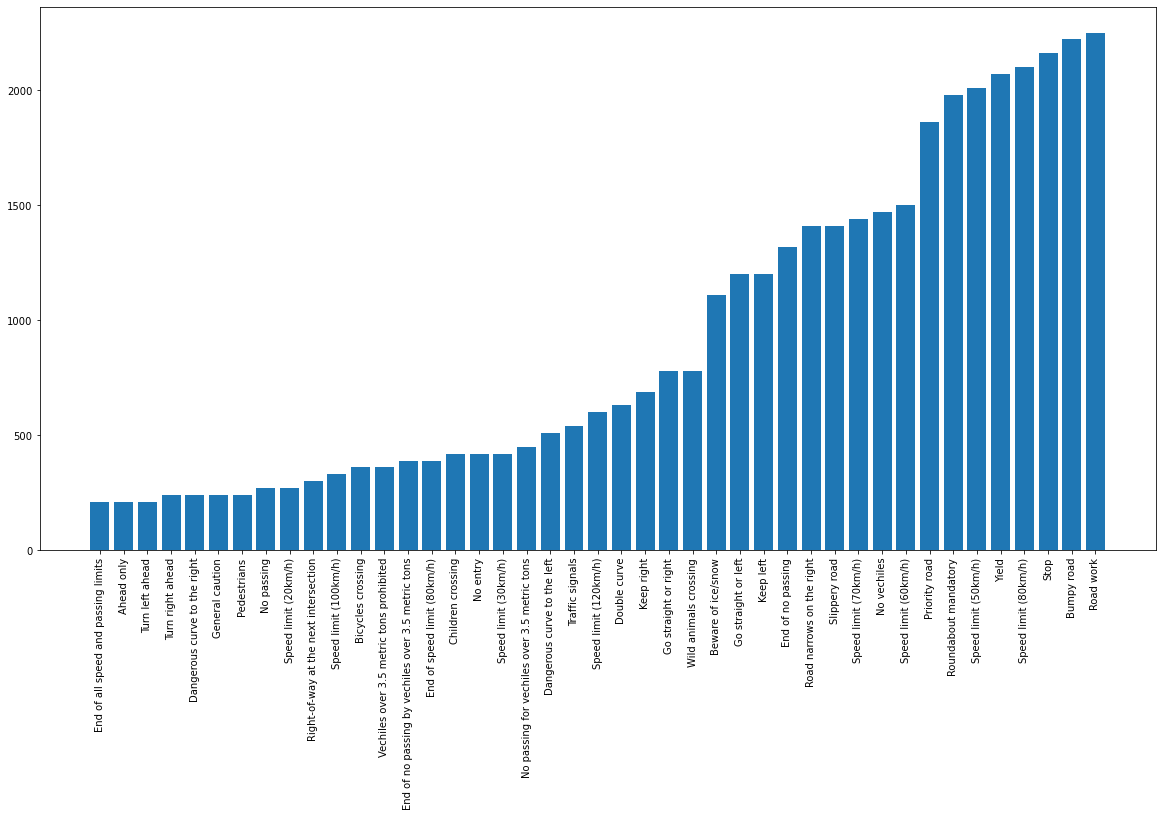

In [34]:
###### Visualising the data

# Get a list of traffic sign names matched to classesId
label_names = pd.read_csv(DATA_PATH+'/sign_names_map.csv')

# Convert into numpy array to allow referencing by index value.
label_names = np.array(label_names.Name)

train_numbers = []
class_names = []

train_path = os.path.join(DATA_PATH, 'train')
directories = os.listdir(train_path)

for dir in directories:
  list_files = os.listdir(train_path + '/' + dir)
  train_numbers.append(len(list_files))
  class_names.append(label_names[int(dir)])

plt.figure(figsize=(20,10))
plt.bar(class_names, sorted(train_numbers))
plt.xticks(class_names, rotation='vertical')
plt.show()


## Image Processing

The next step in to read the images and pre-process them to fit into a trainable format, this includes the dimensions, color or greyscale as the case maybe, putting in mind in the real world it could be colored images or black n white or even very well distorted old signs on the road, we have to account for such scenarios and best we begin thinking about that from the processing of the images to enhance model training.

Firstly, we resize the images into `50x50 pixels`
Secondly, we put the images in a `numpy array`
lastly, we `flatten the image` for `label association` and `model building`.

There's really no need to transform the images to greyscale since to the computer, images are a 2d matrix of numbers ranging from 0-255 in 3 channels RGB color code stack over each other.

In [35]:
# Resizing the images to 50x50  its more suitable in task description
IMAGE_WIDTH = 50
IMAGE_HEIGHT = 50

# Looping through the folder to store the images and respective labels into image and label lists
for i in range(IMAGE_CLASSES):
  path = os.path.join(DATA_PATH, 'train', str(i))
  images_dir = os.listdir(path)
  for j in images_dir:
    try:
      image = Image.open(path + '/' + j)
      image = image.resize((IMAGE_HEIGHT,IMAGE_WIDTH))
      image = np.array(image)
      images.append(image)

      label = np.zeros(43)
      label[i] = 1.0
      labels.append(i)
    except Exception as e:
      print(e)

In [36]:
# Convert image and label data to single dimensional numpy arrays for processing
images = np.array(images)
labels = np.array(labels)

print ('Image shape, size and channel', images.shape)
print ('Image label shape', labels.shape)

Image shape, size and channel (39209, 50, 50, 3)
Image label shape (39209,)


## Model building Prep

To begin building our traffic signs classification model, we will need to import some libraries to help with that, we know we're building a Convolutional Neural Network model so we will be needing `keras` for building and optimizing the model, `sklearn` for metrics, splitting our data to train and test shapes.


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

- Split data with `train_test_split` from sklearn using 80% for training, 20% for testing, and a random_state of 7 to have a steady result across multiple executions to test the effectiveness of our model. 
- Normalize the images by dividing by 255 to get ranges of pixel between 0 - 1.
- Change labels to one hot encoding (categorical to numerical data) since this a categorical problem,to make sure it creates a binary representation of labels to improve accurracy and enable the data to be fed into the model as the model wouldn't be able read categorical data except numerical data.


In [38]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=7, shuffle=True)

# Normalize the images by dividing by 255 to get ranges of pixel from 0 - 1
X_train = X_train/255
X_test = X_test/255

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 50, 50, 3) (7842, 50, 50, 3) (31367,) (7842,)


Let's Visualise some of the images from the dataset before we begin model building.

Plot a random set of 20 images together with their labels.


/var/folders/jv/t35ykn454ms8nfbskc6kd4rw0000gn/T/ipykernel_2244/803142949.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


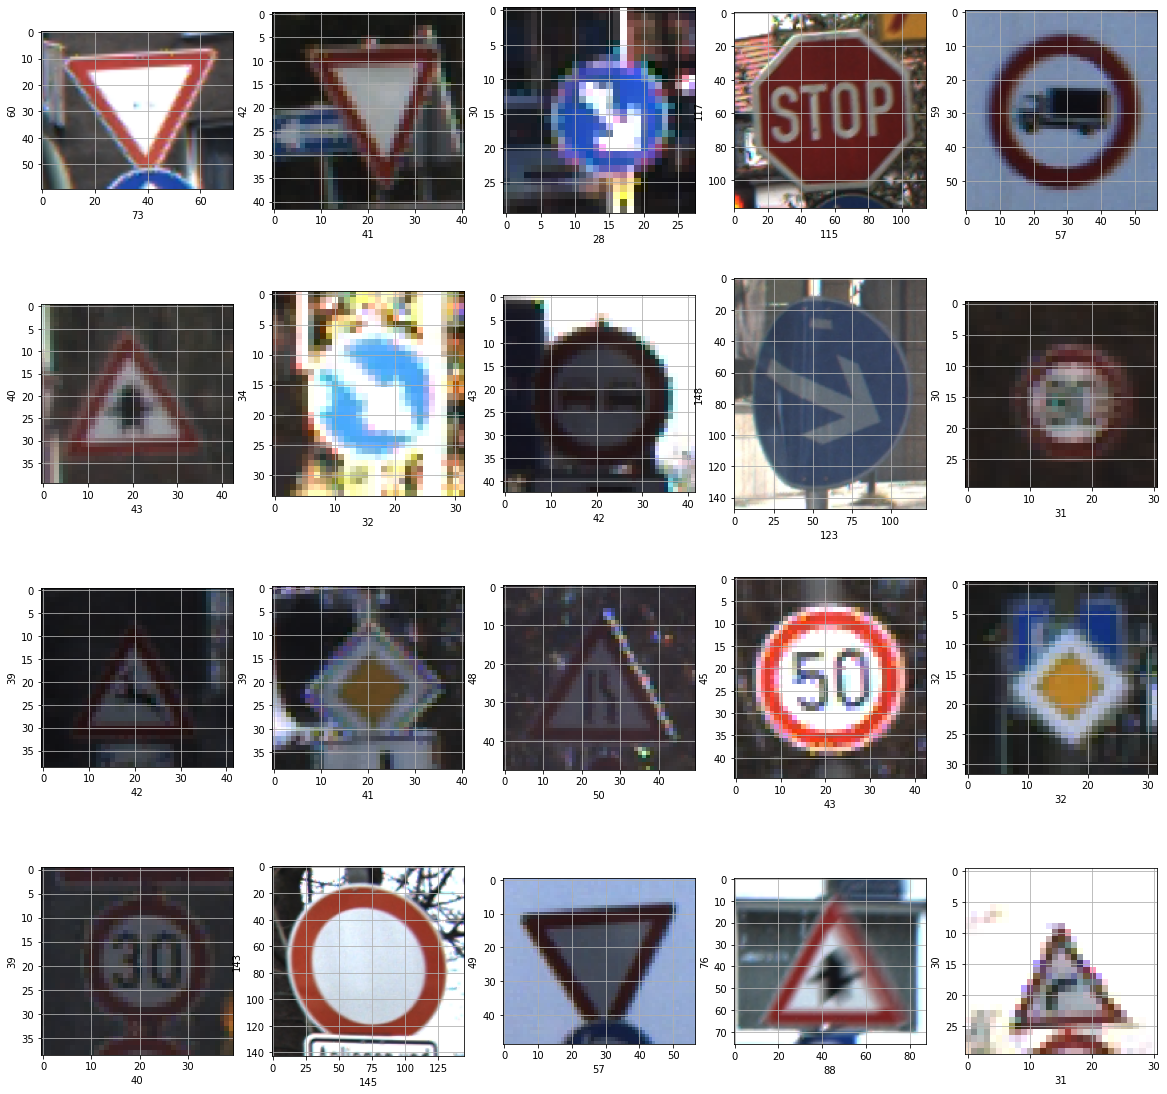

In [39]:
# Visualizing random images from test data

test = pd.read_csv(DATA_PATH + '/test.csv')
imgs = test["Path"].values

plt.figure(figsize=(20,20))

for i in range(1,21):
  plt.subplot(4,5,i)
  random_img_path = DATA_PATH + '/' + random.choice(imgs)
  rand_img = imread(random_img_path)
  img_label = np.argmax(y_train[i])
  plt.imshow(rand_img)
  plt.grid(b=None)
  plt.xlabel(rand_img.shape[1])
  plt.ylabel(rand_img.shape[0])

In [40]:
# Change labels to one hot encoding to make sure a value if larger than the other so it create a binary represnetation of values to improve accurracy.

y_test = to_categorical(y_test, 43)
y_train = to_categorical(y_train, 43)


## Build the CNN model

Using the Sequential model from keras to build the model, we create a convolutional Neural network of 4 inner/hidden layers and one output layer containing image classes shape as the unit.

We use relu as the activation for all layers except output layers, the ReLU activation helps with non-linerity, replacing negative values with zero (0) whilst retaining positive integers in the feature maps.

Input_shape: following the image recommended size of 50x50 and 3 channels of RGB.

We used MaxPool as the Pooling function since its one of the most used and helps reduces dimension x distortions making our model more tolerant to variations.

Dropout was used in every layer to handle overfitting, this offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds. https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/.

Output layers use larger dropout rate between 0.5 - 0.8 as opposed to internal layers. to ensure a fair randomise dropouts from each layer.

The last layer before the output layer, we flattened our data and used Dense to connect the layers into a densely connected neural network.





In [56]:
# Build a CNN Model for traffic signs image classification

cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(BatchNormalization(axis=-1))

cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(BatchNormalization(axis=-1))


cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(BatchNormalization(axis=-1))


cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(rate=0.5))


cnn_model.add(Dense(43, activation='softmax'))


Compile model with `categorical_crossentropy` as loss function, `adam` optimizer and accuracy metric.

In [57]:
# Compile built CNN model

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 64)       

Training the model

Train model with 20 epochs and a batch size of 32, It requires less memory. Since we train the network using fewer samples, the overall training procedure requires less memory. That's especially important if we are not able to fit the whole dataset in your machine's memory.

In [58]:
# Train model
history = cnn_model.fit(X_train, y_train, batch_size=27, epochs=35, validation_data=(X_test, y_test))


Epoch 1/35
1162/1162 [==============================] - 36s 31ms/step - loss: 2.0255 - accuracy: 0.4969 - val_loss: 0.0992 - val_accuracy: 0.9705
Epoch 2/35
1162/1162 [==============================] - 36s 31ms/step - loss: 0.1929 - accuracy: 0.9412 - val_loss: 0.0461 - val_accuracy: 0.9883
Epoch 3/35
1162/1162 [==============================] - 36s 31ms/step - loss: 0.1026 - accuracy: 0.9693 - val_loss: 0.0293 - val_accuracy: 0.9934
Epoch 4/35
1162/1162 [==============================] - 37s 32ms/step - loss: 0.0785 - accuracy: 0.9766 - val_loss: 0.0193 - val_accuracy: 0.9945
Epoch 5/35
1162/1162 [==============================] - 37s 32ms/step - loss: 0.0704 - accuracy: 0.9771 - val_loss: 0.0210 - val_accuracy: 0.9944
Epoch 6/35
1162/1162 [==============================] - 36s 31ms/step - loss: 0.0565 - accuracy: 0.9824 - val_loss: 0.0201 - val_accuracy: 0.9948
Epoch 7/35
1162/1162 [==============================] - 36s 31ms/step - loss: 0.0493 - accuracy: 0.9844 - val_loss: 0.0297 -

In [59]:
# Evaluate the trained model to see how it performed with the data shown.

score = cnn_model.evaluate(X_test,y_test,verbose=0)

print('Test Score:',score[0])
print('Test Accuracy:',score[1])


Test Score: 0.00404141191393137
Test Accuracy: 0.9987248182296753


Looking at the accuracy and loss graph, we can conclude that the model maintains a steady line from the 30th epochs.

We might have to reduce the epoch to a max of 30.


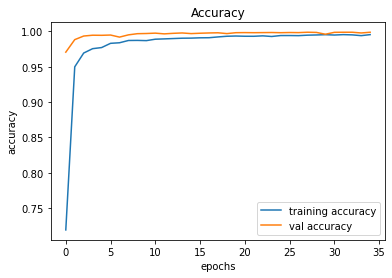

In [60]:
# Plot accuracy graph 

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


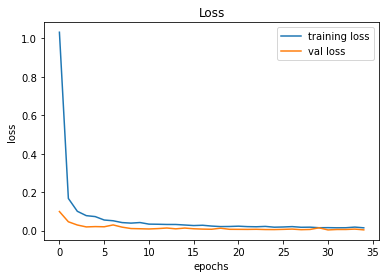

In [61]:
# Plot Loss graphs

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

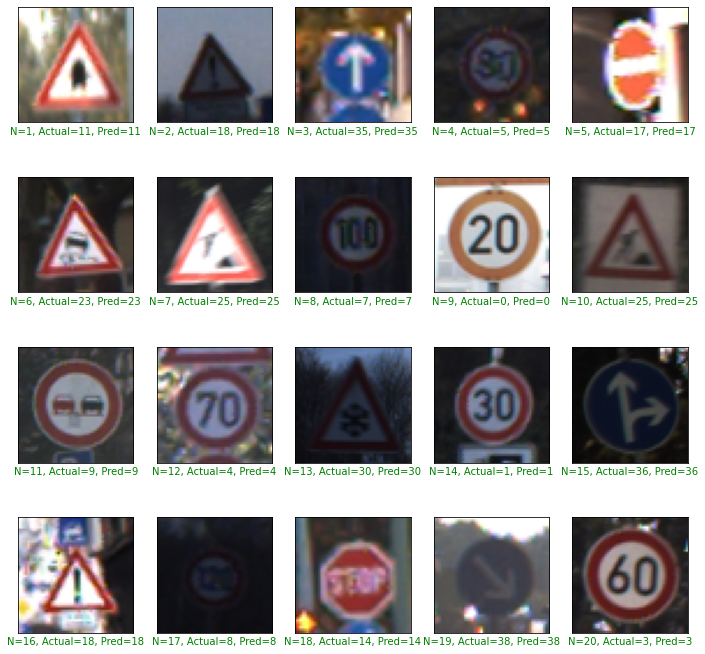

In [62]:
# Visual Result of prediction on test data

preds = cnn_model.predict(X_test)

plt.figure(figsize=(12, 12))

for i in range(1,21):
  plt.subplot(4, 5, i)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  prediction = np.argmax(preds[i])
  actual = np.argmax(y_test[i])
    
  col = 'g'
  if prediction != actual:
    col = 'r'
    
  plt.xlabel('N={}, Actual={}, Pred={}'.format(i, actual, prediction), color=col)
  plt.imshow(X_test[i], cmap='gray')
plt.show()

The model not only seem accurate but also seems to be predicting correctly.

The challenge now we have an unbalanced distribution of classes in our dataset, so accuracy metric alone will not give us the true accuracy of our model's performance.

We're solving imbalanced data with through metrics.
Another option to address class imbalance issues is to utilise more accurate metrics, such as the F1 score, which include not only the amount of prediction mistakes produced by your model, but also the type of errors made.

In [117]:
from sklearn.metrics import precision_score, recall_score
print('Precision is: ', precision_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='micro'))
print('Recall is: ', recall_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='micro'))

Precision is:  0.9987248150981892
Recall is:  0.9987248150981892


In [112]:
from sklearn.metrics import f1_score
print('F1 is: ', f1_score(np.argmax(y_test, axis=-1), np.argmax(preds, axis=-1), average='micro'))

F1 is:  0.9987248150981892


Well, I guess our accuracy scores where right as the `precision`, `recall` and `F1` all have a score of `99%`

## Test model on files in the Test directory


In [124]:
test = pd.read_csv(DATA_PATH + '/test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
  try:
    image = cv2.imread(DATA_PATH + '/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    data.append(np.array(resize_image))
  except Exception as e:
    print(e)

X_tests = np.array(data)
X_tests = X_tests/255

pred_nd_array = cnn_model.predict(X_tests)
pred = np.argmax(pred_nd_array, axis=1)

print('Test Data accuracy: ', accuracy_score(labels, pred, normalize=True))

Test Data accuracy:  0.8688044338875692


Confusion Matrix and Classification Report of tests data

In [129]:
cm = confusion_matrix(labels, pred)
cm

array([[ 59,   0,   0, ...,   0,   0,   0],
       [  0, 717,   1, ...,   0,   0,   0],
       [  0,   2, 747, ...,   0,   0,   0],
       ...,
       [  4,   1,   6, ...,  18,   0,   0],
       [  0,   0,   0, ...,   0,  52,   0],
       [  0,   0,   0, ...,   0,   0,  90]])

<AxesSubplot:>

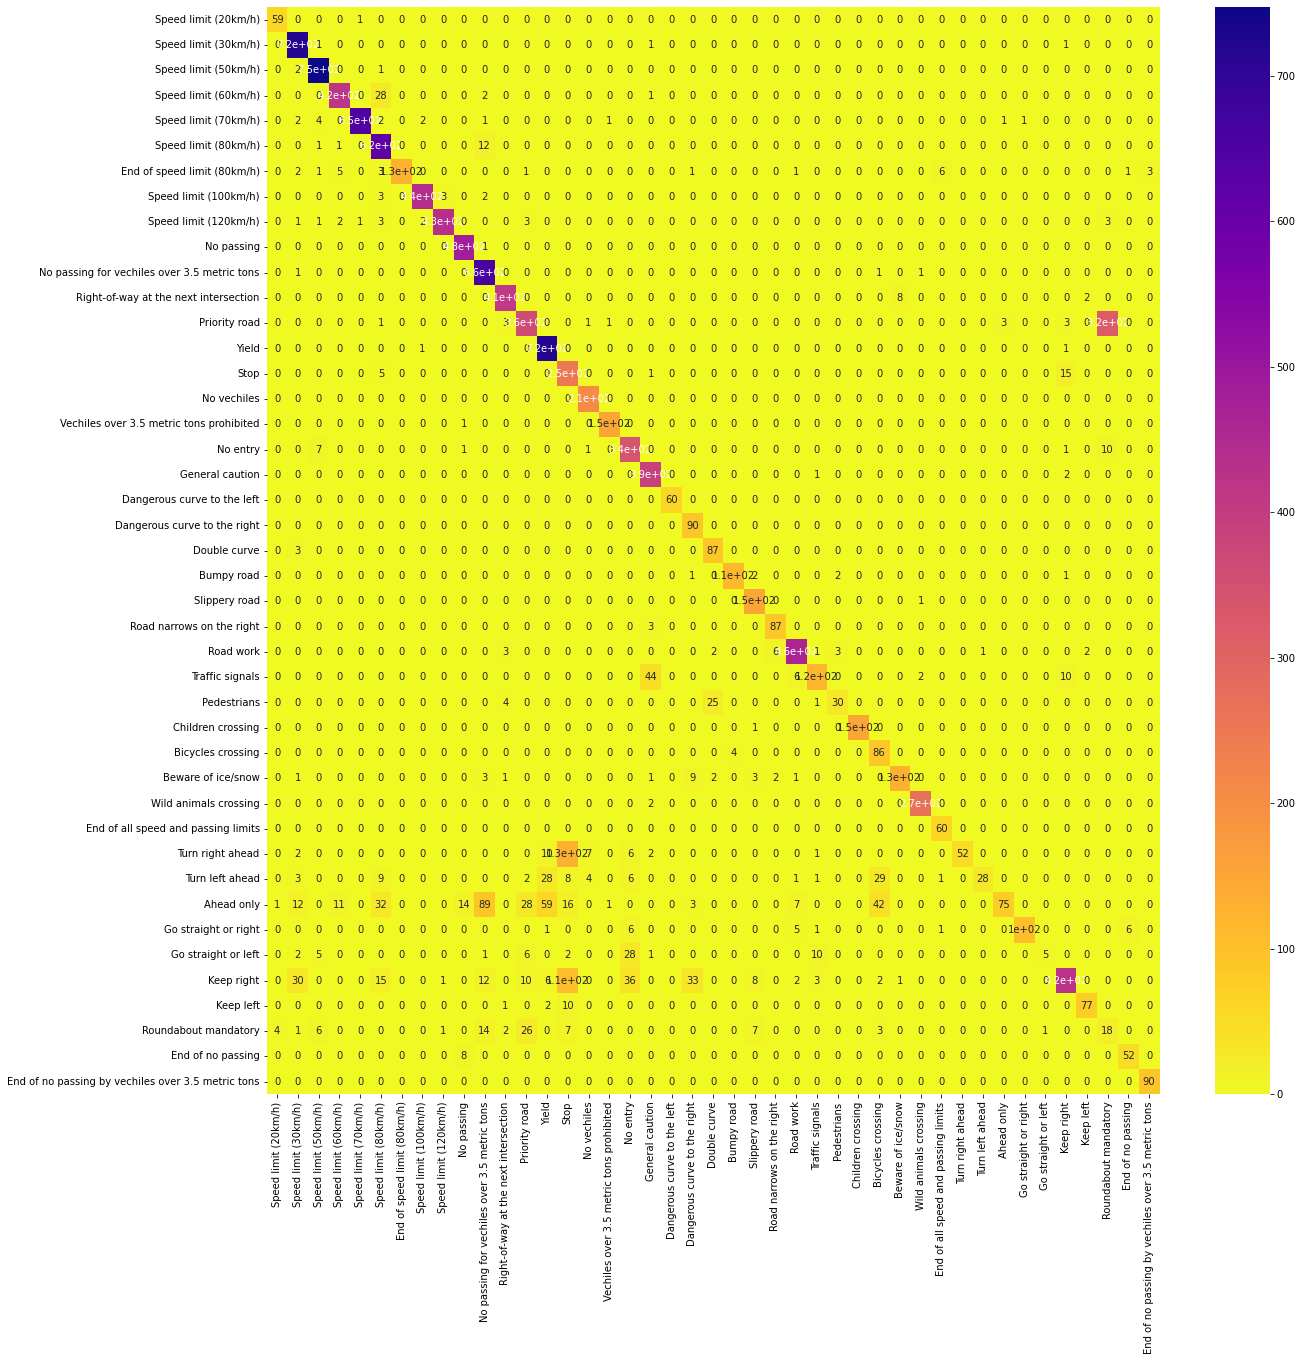

In [126]:
# Visualise the confusion matrix
import seaborn as sns

df_cm = pd.DataFrame(cm, index = label_names,  columns = label_names)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, cmap='plasma_r')